# Time Series Analysis

In [1]:
%%capture

!pip install --upgrade pandas-datareader
!pip install ffn yfinance

## Preliminary Knowledge
- We follow Prof. Chen's slides: http://homepage.ntu.edu.tw/~sschen/Book/Slides/Ch2Basic.pdf
- I suggest that you could read the slides from [Lesson 1](http://www.phdeconomics.sssup.it/documents/Lesson1.pdf) to [Lesson 15](http://www.phdeconomics.sssup.it/documents/Lesson15.pdf).

In [2]:
import ffn
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import date, timedelta
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
import statsmodels.graphics as smg
from statsmodels import tsa

params = {'legend.fontsize': 'x-large',
      'figure.figsize': (12, 6),
      'axes.labelsize': 'x-large',
      'axes.titlesize': 'x-large',
      'xtick.labelsize': 'x-large',
      'ytick.labelsize': 'x-large'}
plt.rcParams.update(params)
sns.set_style("whitegrid")

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Autocorrelation
- Let $X \sim (0, \sigma^2_X)$ and $Y \sim (0, \sigma^2_Y)$.
- Recall that $X$ and $Y$ are (linearly) correlated if $\rho_{XY} = \mathbf{Corr}(X, Y) = \dfrac{\mathbf{E}(XY)}{\sigma_X\sigma_Y}$.
- Now replace $X$ by $X_i$ and $Y$ by $X_{i - k}$.
- Then we have $\rho_{i, i - k} = \mathbf{Corr}(X_i, X_{i - k}) = \dfrac{\mathbf{E}(X_i X_{i - k})}{\sigma_{X_i}\sigma_{X_{i - k}}}$ for some $k \geq 0$.

In [3]:
twse = yf.download("^twii", period = "1y")
twse = pd.DataFrame(twse["Adj Close"])
twse.columns = ["twii"]
twse

[*********************100%***********************]  1 of 1 completed


,twii
Date,
2020-07-08,12170.190430
2020-07-09,12192.690430
2020-07-10,12073.679688
2020-07-13,12211.559570
2020-07-14,12209.009766
...,...
2021-07-02,17710.150391
2021-07-05,17919.330078
2021-07-06,17913.070312


In [4]:
twse["twii"].autocorr()

0.9960480385932755

In [5]:
twse["return rate"] = twse["twii"].pct_change().dropna()
rho = twse["return rate"].autocorr()
rho

0.012734076414602216

In [6]:
autocorr = {}
for i in range(20):
    rho = twse["return rate"].autocorr(i)
    autocorr[i] = rho

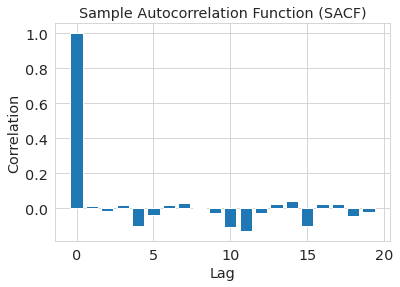

In [7]:
plt.figure()
plt.bar(autocorr.keys(), autocorr.values())
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.title("Sample Autocorrelation Function (SACF)")
plt.grid(True)

### Stationariness
- The definition of **strongly stationary** processes can be found [here](https://en.wikipedia.org/wiki/Stationary_process#Strict-sense_stationarity).
- We here consider the **weakly stationary** processes, which have no trend/seasonal components and behaves like a **white noise**.
- Note that both stationariness definitions are equivalent when it comes to the Gaussian processes.

#### Example: White Noise
- $\{X_i\}$ is a white noise if $X_i \sim^{iid} N(0, \sigma^2)$ for some constant $\sigma > 0.$

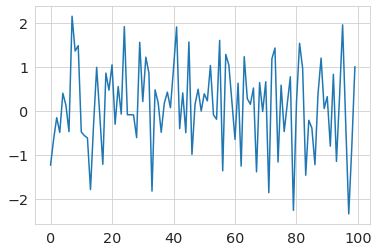

In [8]:
import numpy as np

e = np.random.normal(size = 100)
plt.plot(e)
plt.grid(True)

## Autoregressive (AR) Model
- $\{y_t\}$ is an AR$(p)$ model if $\{y_t\}$ follows 
$$y_t = \theta_{t - 1} y_{t - 1} + \theta_{t - 2} y_{t - 2} + \cdots + \theta_{t - p} y_{t - p} + \varepsilon_t = \sum_{i = 1}^p \theta_{t - i} y_{t - i} + \varepsilon_t.$$

### Example 1: AR(1) Process
- Let $\{y_t\}$ be one AR(1) model with $\theta_{t - 1}.$

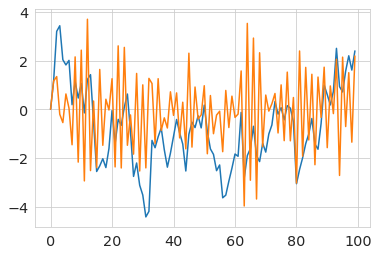

In [9]:
e = np.random.normal(size = 100)
theta_candidate = [0.8, -0.8]
y = np.zeros(e.shape)
for theta in theta_candidate:
    y[0] = 0
    for i in range(1, len(e)):
        y[i] = theta * y[i - 1] + e[i]
    plt.plot(y)
plt.grid(True)

### Example 2: AR(2) Process
- Let $\{y_t\}$ be one AR(2) model with $\theta_{t - 1}$ and $\theta_{t - 2}$.

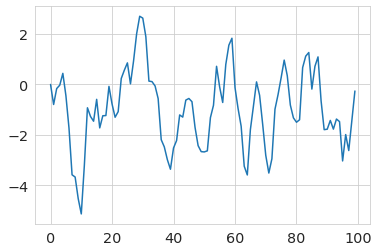

In [10]:
e = np.random.normal(size = 100)
theta_1 = 0.9
theta_2 = -0.1

y = np.zeros(e.shape)
for i in range(1, len(e)):
    y[i] = theta_1 * y[i - 1] + theta_2 * y[i - 2] + e[i]
plt.plot(y)
plt.grid(True)

### Example 3: Random Walk
- **Random walk is not stationary.**
- $\{X_i\}$ is a random walk if $X_0$ = 0 and $X_{i + 1} = X_{i} + \varepsilon_i$ where $\varepsilon_i \sim N(0, \sigma^2)$ for some constant $\sigma > 0.$
- Let $Y_n = \sum_{i = 0}^t X_i$. Then it is clear that $Y_t \sim N(0, t\sigma^2)$.
- $Y_t$ is also called [the Brownian motion](https://en.wikipedia.org/wiki/Brownian_motion).



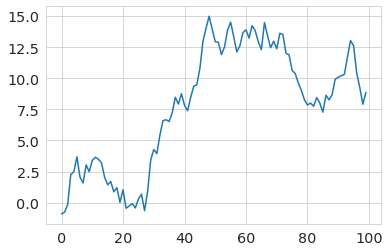

In [11]:
np.random.seed(1985)
e = np.random.normal(size = 100)
X = np.cumsum(e)
plt.plot(X)
plt.grid(True)

#### Concept: Integration
- The order of integration, denoted by $I(d)$ for some positive integer $d$, of a time series is a summary statistic, which reports the minimum number of differences required to obtain a stationary series.
- For example, $X$ is an $I(1)$ process because the first difference of $X$ becomes a stationary process.
- References
    - https://en.wikipedia.org/wiki/Order_of_integration

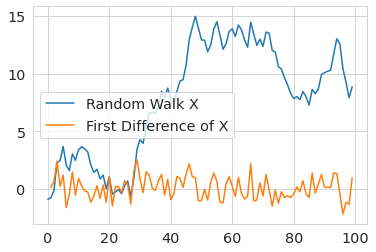

In [12]:
dX = np.diff(X)
plt.plot(X)
plt.plot(range(1, len(dX) + 1), dX)
plt.grid(True)
plt.legend(["Random Walk X", "First Difference of X"])

#### Unit Root Test
- The time series is not stationary if and only if the time series has a unit root.
- Use [augmented Dickey-Fuller unit root test](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html) to check if there is a unit root in one time series.
- References
    - [單根與隨機趨勢](http://homepage.ntu.edu.tw/~sschen/Book/Slides/Ch6Unitroot.pdf) by Prof. Chen.


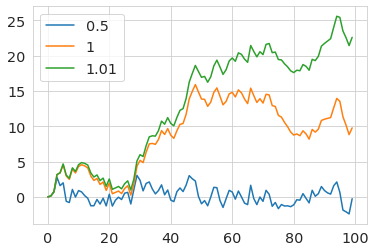

In [13]:
theta = [0.5, 1, 1.01]
y = np.zeros((e.shape[0], 3))

for idx, curr_theta in enumerate(theta):
    y[0, idx] = 0
    for i in range(1, len(e)):
        y[i, idx] = curr_theta * y[i - 1, idx] + e[i]
    plt.plot(y[:, idx])
plt.grid(True)
plt.legend([str(x) for x in theta])

In [14]:
for i in range(3):
    print("p-value =", sm.tsa.stattools.adfuller(y[:, i], regression = "nc")[1])

p-value = 6.147740636810894e-07
p-value = 0.6819062223626149
p-value = 0.9570985403860577


## Moving-Average (MA) Model
- $\{y_t\}$ is an MA$(q)$ model if $\{y_t\}$ follows 
$$y_t = \varepsilon_t + \phi_{t - 1} \varepsilon_{t - 1} + \phi_{t - 2} \varepsilon_{t - 2} + \cdots + \phi_{t - p} \varepsilon_{t - q} + \varepsilon_t = \varepsilon_t + \sum_{i = 1}^q \phi_{t - i} \varepsilon_{t - i}.$$

### Example: MA(1) Process
- Let $\{y_t\}$ be one MA(1) model with $\phi_{t - 1}.$

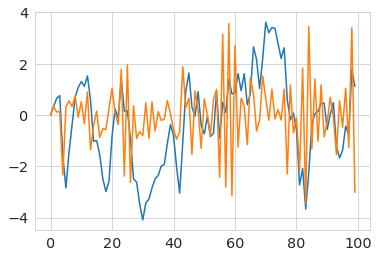

In [15]:
e = np.random.normal(size = 100)
phi_candidate = [0.8, -0.8]

y = np.zeros(e.shape)
for phi in phi_candidate:
    y[0] = 0
    for i in range(1, len(e)):
        y[i] = phi * y[i - 1] + e[i]
    plt.plot(y)
plt.grid(True)

## Autoregressive Moving-Average (ARMA) Model 
- How to build the ARMA models? [Building ARMA models: Examples](http://www.phdeconomics.sssup.it/documents/Lesson15.pdf).
    - Also read my [notes](https://hackmd.io/@arthurzllu/BkJJlHBoE) on Financial Data Analysis held by Prof. Daniel Miao (繆維中).

<center>    
<img src = "https://pic2.zhimg.com/80/v2-f63f3e52f0f793a02d60e6d9757d3d5d_hd.jpg" width = 600></img>
</center>

- Glossary
    - [Box-Jenkins method](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method): find the best fit of a time-series model to past values of a time series.
        - You may read [these slides](http://www.phdeconomics.sssup.it/documents/Lesson13.pdf) for details.
    - [Ljung-Box test](https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test): whether any of a group of autocorrelations of a time series are different from zero; it can be used to test if the time series is a random walk.

- References:
    - Tutorial of time series (in R): https://kevinkotze.github.io/ts-1-tut/ (change the middle number from 1 to 10 for all tutorials)
    - https://www.asc.ohio-state.edu/de-jong.8/note2.pdf
    - [ARIMA Model – Complete Guide to Time Series Forecasting in Python](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)
    - [Time Series Analysis in Python: Linear Models to GARCH Models](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016) (利用python进行时间序列分析-从随机游走到GARCH模型: <a href = "https://zhuanlan.zhihu.com/p/35409323">1</a>, <a href = "https://zhuanlan.zhihu.com/p/35414753">2</a>, <a href = "https://zhuanlan.zhihu.com/p/35417133">3</a>)
    - Another python package for time series analysis: https://pyflux.readthedocs.io/en/latest/


### Example 1

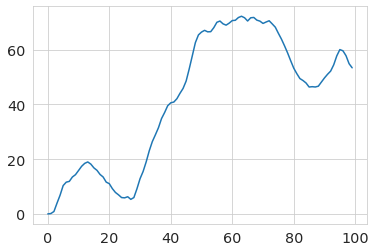

In [16]:
np.random.seed(1985)
e = np.random.normal(size = 100)
theta_1 = 0.9
theta_2 = -0.1

y = np.zeros(e.shape)
for i in range(1, len(e)):
    y[i] = theta_1 * y[i - 1] + theta_2 * y[i - 2] + e[i]

y = np.cumsum(y)
plt.plot(y)

In [17]:
sm.tsa.stattools.adfuller(y)

(-1.7732398366665083,
 0.3938259501946564,
 2,
 97,
 {'1%': -3.4996365338407074,
  '10%': -2.5829283377617176,
  '5%': -2.8918307730370025},
 246.8269582599994)

In [18]:
dy = np.diff(y)
sm.tsa.stattools.adfuller(dy)

(-3.1421138768004706,
 0.0235895256006022,
 1,
 97,
 {'1%': -3.4996365338407074,
  '10%': -2.5829283377617176,
  '5%': -2.8918307730370025},
 245.10874198168145)

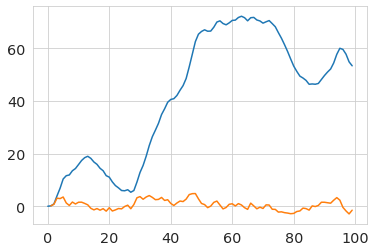

In [19]:
plt.plot(y)
plt.plot(range(1, len(y)), dy)

In [20]:
train = y[:80]
test = y[80:]

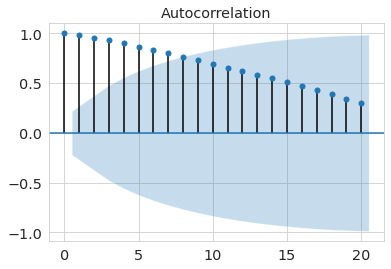

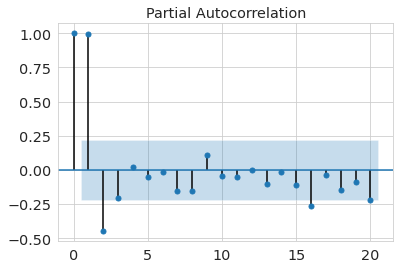

In [21]:
smg.tsaplots.plot_acf(train, lags = 20)
smg.tsaplots.plot_pacf(train, lags = 20)
print()

In [22]:
model = sm.tsa.ARIMA(train, (2, 1, 0)).fit(disp = False)
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   79
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -111.946
Method:                       css-mle   S.D. of innovations              0.990
Date:                Thu, 08 Jul 2021   AIC                            231.891
Time:                        04:19:16   BIC                            241.369
Sample:                             1   HQIC                           235.688
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5024      0.633      0.794      0.430      -0.738       1.743
ar.L1.D.y      0.9444      0.111      8.492      0.000       0.726       1.162
ar.L2.D.y     -0.1136      0.113     -1.003      0.3

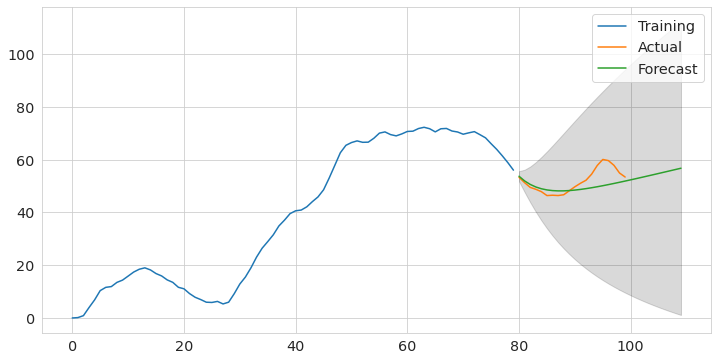

In [23]:
fc, se, conf = model.forecast(30, alpha = 0.05)

plt.figure(figsize = (12, 6))
plt.plot(range(0, 80), train, label = "Training")
plt.plot(range(80, 100), test, label = "Actual")
plt.plot(range(80, 110), fc, label = "Forecast")
plt.fill_between(range(80, 110), conf[:, 0], conf[:, 1], color = "k", alpha = 0.15)
plt.legend()
plt.show()

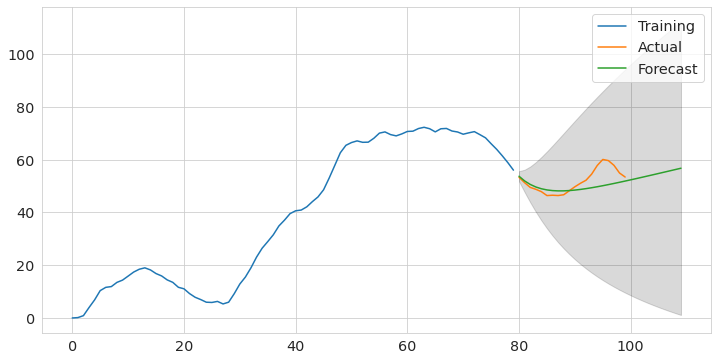

In [24]:
fc, se, conf = model.forecast(30, alpha = 0.05)

plt.figure(figsize = (12, 6))
plt.plot(range(0, 80), train, label = "Training")
plt.plot(range(80, 100), test, label = "Actual")
plt.plot(range(80, 110), fc, label = "Forecast")
plt.fill_between(range(80, 110), conf[:, 0], conf[:, 1], color = "k", alpha = 0.15)
plt.legend()
plt.show()

### Example 2: CPI Inflation
- Consumer Price Index [link](https://en.wikipedia.org/wiki/Consumer_price_index)
- References
    - https://www.rateinflation.com/consumer-price-index/usa-historical-cpi/
    - https://www.rateinflation.com/inflation-rate/usa-historical-inflation-rate/

In [25]:
!wget https://www.csie.ntu.edu.tw/~d00922011/python/data/us_cpi.xlsx

--2021-07-08 04:19:17--  https://www.csie.ntu.edu.tw/~d00922011/python/data/us_cpi.xlsx
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12394 (12K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘us_cpi.xlsx.7’

us_cpi.xlsx.7       100%[===================>]  12.10K  --.-KB/s    in 0s      

2021-07-08 04:19:17 (150 MB/s) - ‘us_cpi.xlsx.7’ saved [12394/12394]



In [26]:
df = pd.read_excel("us_cpi.xlsx")
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
df["Inflation"] = df["CPI"].pct_change()
df.dropna(inplace = True)

df

,CPI,Inflation
Date,,
2011-02-01,221.898,0.003214
2011-03-01,223.046,0.005174
2011-04-01,224.093,0.004694
2011-05-01,224.806,0.003182
2011-06-01,224.806,0.000000
...,...,...
2020-11-01,260.927,0.001785
2020-12-01,261.560,0.002426
2021-01-01,262.231,0.002565


In [27]:
train_size = round(df.shape[0] * 0.8)
train_size

98

In [28]:
train = df["Inflation"][:train_size]
test = df["Inflation"][train_size:]

In [29]:
sm.tsa.stattools.adfuller(train)

(-6.735206570026662,
 3.2205526310016106e-09,
 1,
 96,
 {'1%': -3.5003788874873405,
  '10%': -2.5830997960069446,
  '5%': -2.8921519665075235},
 -818.1719921194459)

In [30]:
sm.tsa.stattools.arma_order_select_ic(train, ic = ['aic', 'bic'], trend = 'nc')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:651: RuntimeWarning: invalid value encountered in arctanh
  invarcoefs = 2*np.arctanh(params)


{'aic':             0           1           2
 0         NaN -923.189466 -929.364478
 1 -930.952700 -929.018334 -939.435718
 2 -929.004698 -938.215835 -937.886036
 3 -927.504057 -939.148945         NaN
 4 -932.645496 -938.234383 -936.511880,
 'aic_min_order': (1, 2),
 'bic':             0           1           2
 0         NaN -918.019531 -921.609576
 1 -925.782765 -921.263431 -929.095848
 2 -921.249796 -927.875965 -924.961198
 3 -917.164187 -926.224108         NaN
 4 -919.720659 -922.724578 -918.417108,
 'bic_min_order': (1, 2)}

In [31]:
model2 = sm.tsa.ARMA(train, (1, 2)).fit(disp = False)
print(model2.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:              Inflation   No. Observations:                   98
Model:                     ARMA(1, 2)   Log Likelihood                 476.555
Method:                       css-mle   S.D. of innovations              0.002
Date:                Thu, 08 Jul 2021   AIC                           -943.110
Time:                        04:19:20   BIC                           -930.185
Sample:                    02-01-2011   HQIC                          -937.882
                         - 03-01-2019                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0014      0.000      4.998      0.000       0.001       0.002
ar.L1.Inflation    -0.2277      0.316     -0.721      0.473      -0.847       0.391
ma.L1.Inflation     0.6515      

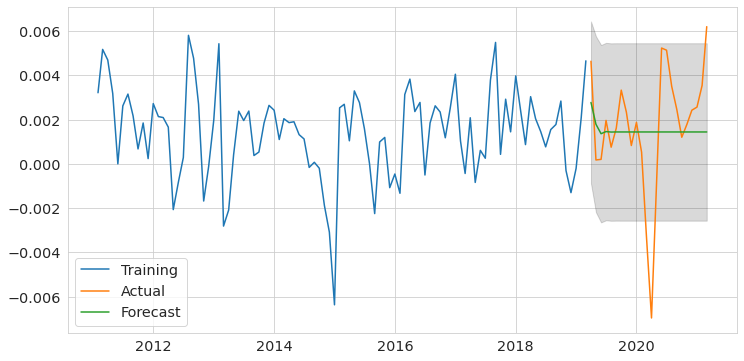

In [32]:
fc, se, conf = model2.forecast(df.shape[0] - train_size, alpha = 0.05)

fc_series = pd.Series(fc, index = test.index)
lower_series = pd.Series(conf[:, 0], index = test.index)
upper_series = pd.Series(conf[:, 1], index = test.index)

plt.figure(figsize = (12, 6))
plt.plot(train, label = "Training")
plt.plot(test, label = "Actual")
plt.plot(fc_series, label = "Forecast")
plt.fill_between(lower_series.index, lower_series, upper_series, color = "k", alpha = 0.15)
plt.legend()
plt.show()

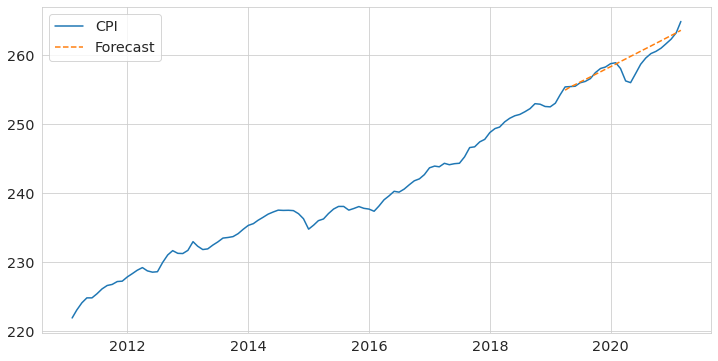

In [33]:
plt.figure(figsize = (12, 6))
plt.plot(df["CPI"], label = "CPI")
plt.plot(df["CPI"][train_size - 1] * np.cumprod(1 + fc_series), "--", label = "Forecast")
plt.legend()
plt.show()

### Example 3: S&P 500 Index

In [34]:
tbl = pd.DataFrame(yf.download("^GSPC", start = "2019-07-08", end = "2021-07-06")["Adj Close"])
tbl.columns = ["gspc"]
tbl

[*********************100%***********************]  1 of 1 completed


,gspc
Date,
2019-07-08,2975.949951
2019-07-09,2979.629883
2019-07-10,2993.070068
2019-07-11,2999.909912
2019-07-12,3013.770020
...,...
2021-06-28,4290.609863
2021-06-29,4291.799805
2021-06-30,4297.500000


In [35]:
sm.tsa.stattools.adfuller(tbl["gspc"])

(-0.36835108218073365,
 0.9152504178495982,
 9,
 493,
 {'1%': -3.4436840273842058,
  '10%': -2.5699020441557052,
  '5%': -2.8674204319994674},
 5054.815002073667)

In [36]:
tbl["return rate"] = tbl["gspc"].pct_change()
tbl.dropna(inplace = True)

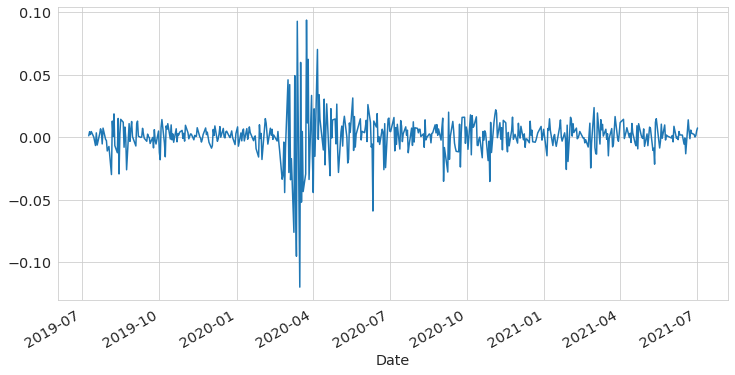

In [37]:
tbl["return rate"].plot.line(figsize = (12, 6))

In [38]:
sm.tsa.stattools.adfuller(tbl["return rate"])

(-6.158582506836592,
 7.266610093713244e-08,
 8,
 493,
 {'1%': -3.4436840273842058,
  '10%': -2.5699020441557052,
  '5%': -2.8674204319994674},
 -2698.568096626685)

In [39]:
train_size = round(tbl.shape[0] * 0.8)
train_size

402

In [40]:
train = tbl["return rate"][:train_size]
test = tbl["return rate"][train_size:]

In [41]:
tsa.stattools.arma_order_select_ic(train, ic = ['aic', 'bic'], trend = 'nc')

{'aic':              0            1            2
 0          NaN -2121.199171 -2150.361098
 1 -2135.278331 -2138.885232 -2150.021074
 2 -2144.296947 -2143.839795 -2188.849578
 3 -2146.876018 -2186.633390 -2188.447045
 4 -2156.153450 -2186.579698 -2185.039085,
 'aic_min_order': (2, 2),
 'bic':              0            1            2
 0          NaN -2113.206267 -2138.371741
 1 -2127.285427 -2126.895875 -2134.035265
 2 -2132.307591 -2127.853986 -2168.867318
 3 -2130.890209 -2166.651129 -2164.468333
 4 -2136.171189 -2162.600986 -2157.063921,
 'bic_min_order': (2, 2)}

In [42]:
model = sm.tsa.ARMA(train.dropna(), (2, 2)).fit(disp = False)
print(model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:            return rate   No. Observations:                  402
Model:                     ARMA(2, 2)   Log Likelihood                1100.187
Method:                       css-mle   S.D. of innovations              0.016
Date:                Thu, 08 Jul 2021   AIC                          -2188.373
Time:                        04:19:24   BIC                          -2164.394
Sample:                             0   HQIC                         -2178.879
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0008      0.001      1.236      0.217      -0.000       0.002
ar.L1.return rate    -1.7362      0.038    -45.618      0.000      -1.811      -1.662
ar.L2.return rate    -0.

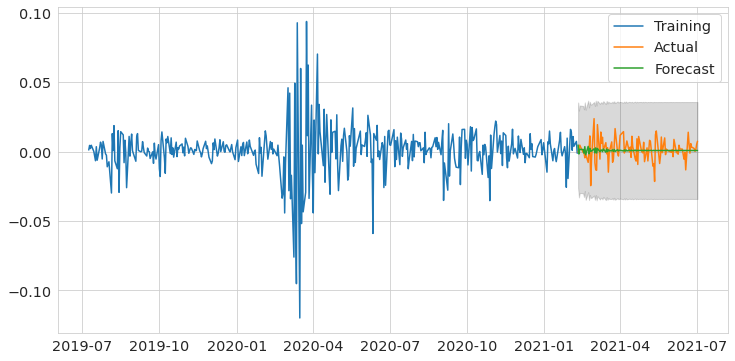

In [43]:
fc, se, conf = model.forecast(tbl.shape[0] - train_size, alpha = 0.05)

fc_series = pd.Series(fc, index = test.index)
lower_series = pd.Series(conf[:, 0], index = test.index)
upper_series = pd.Series(conf[:, 1], index = test.index)

plt.figure(figsize = (12, 6))
plt.plot(train, label = "Training")
plt.plot(test, label = "Actual")
plt.plot(fc_series, label = "Forecast")
plt.fill_between(lower_series.index, lower_series, upper_series, color = "k", alpha = 0.15)
plt.legend()
plt.show()

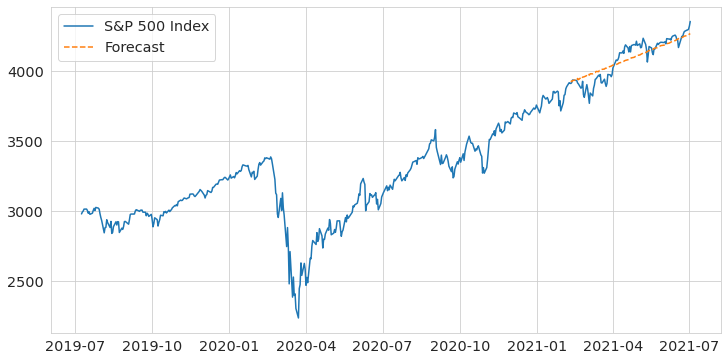

In [44]:
plt.figure(figsize = (12, 6))
plt.plot(tbl["gspc"], label = "S&P 500 Index")
plt.plot(tbl["gspc"][train_size - 1] * np.cumprod(1 + fc_series), "--", label = "Forecast")
plt.legend()
plt.show()

### More Examples
* [Trends and Cycles in Unemployment](https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_cycles.html) with [time-series filters](https://www.statsmodels.org/devel/examples/notebooks/generated/tsa_filters.html).
    * As to the Hodrick-Prescott (HP) filter, you could read Prof. Chen's slides mentioned earlier.
- [Detrending, Stylized Facts and the Business Cycle](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_structural_harvey_jaeger.html).